# Gas-Diesel Price Prediction

This notebook develops the models used for predicting gas and diesel prices.  The model hyperparameter selection is also done here; these hyperparameters are used in the continuously integrating model.

Data from https://www.eia.gov/petroleum/gasdiesel/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import time
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from bayes_opt import BayesianOptimization

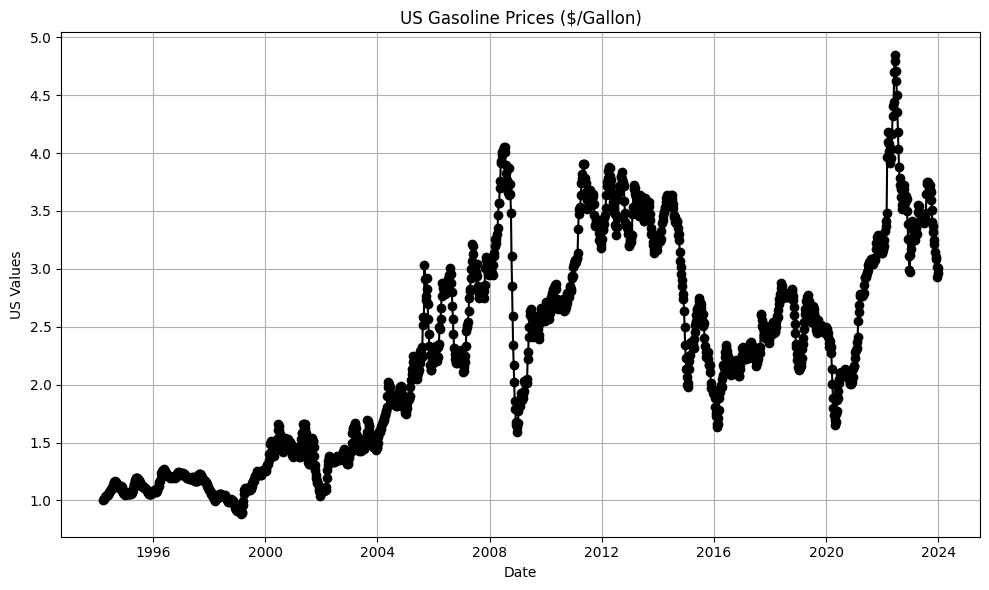

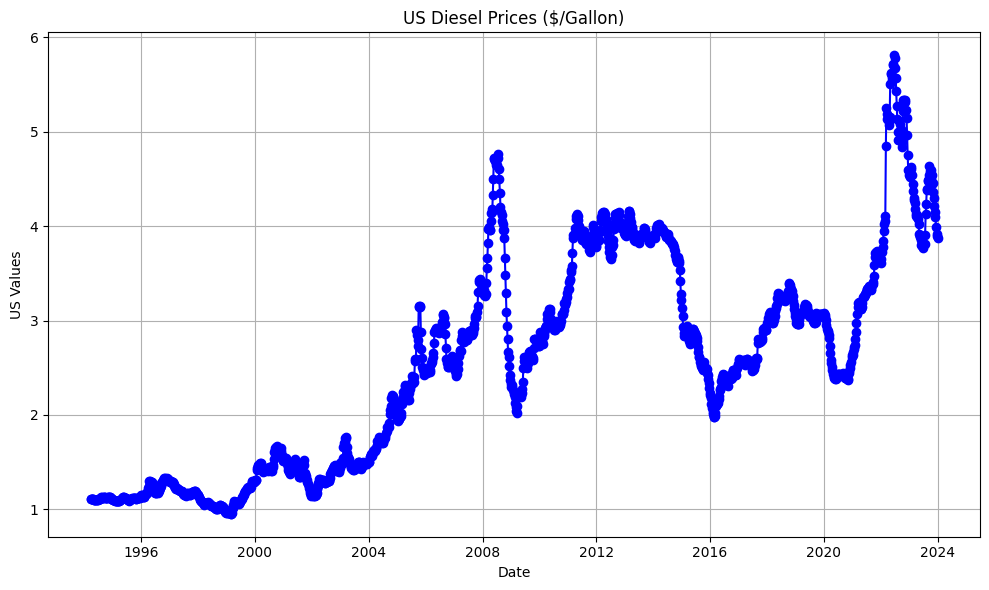

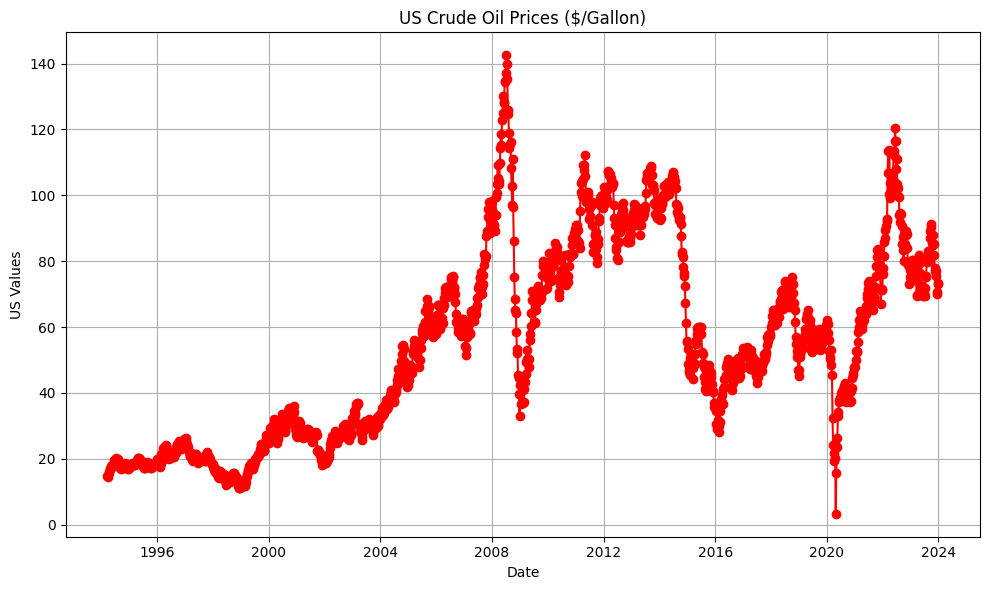

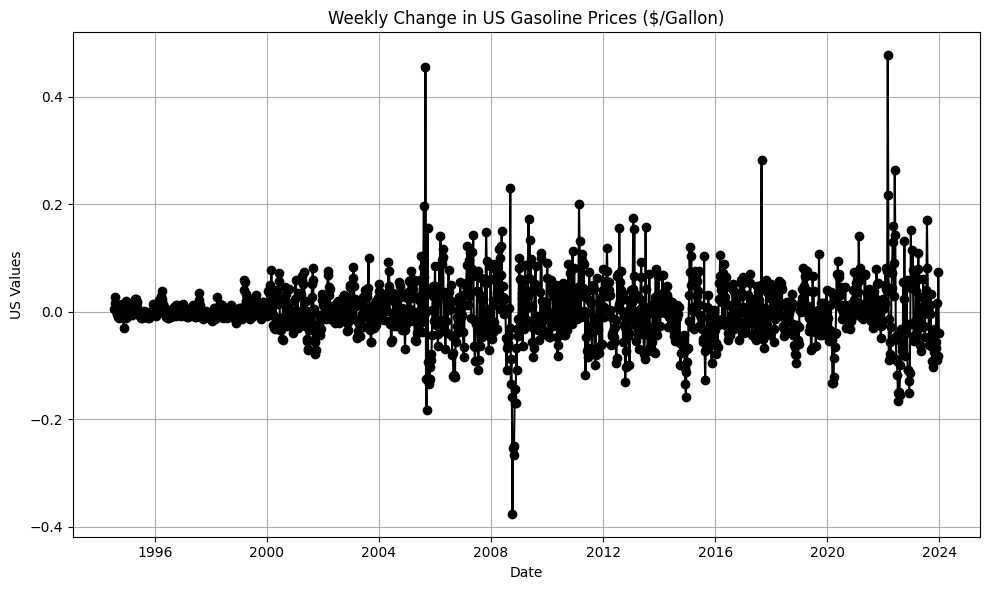

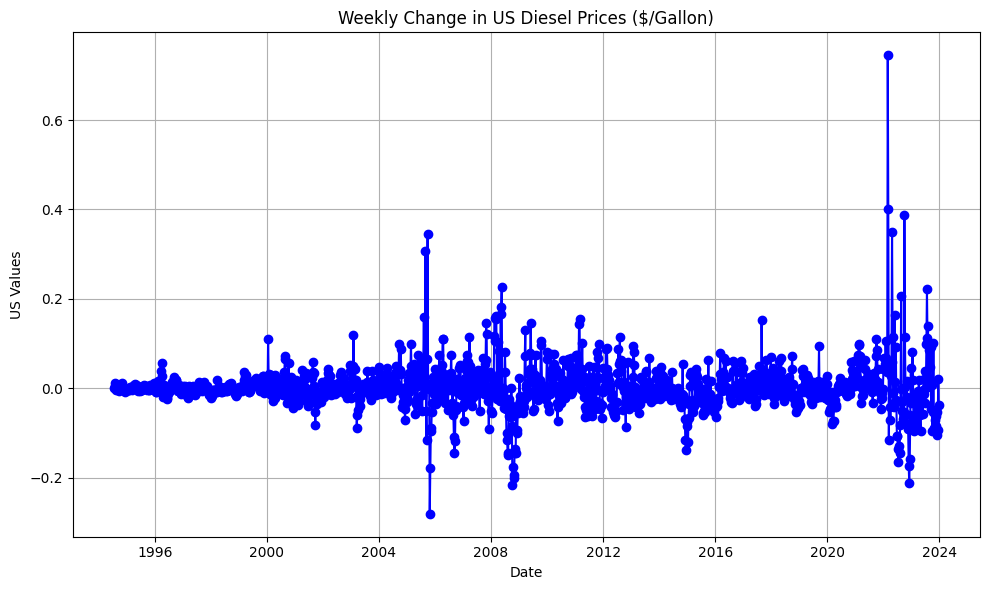

,Gasoline,Diesel,Crude,GasolineDiff1,DieselDiff1,CrudeDiff1,GasolineDiff2,DieselDiff2,CrudeDiff2,GasolineDiff3,...,DieselDiff15,CrudeDiff15,GasolineDiff16,DieselDiff16,CrudeDiff16,GasolineDiff17,DieselDiff17,CrudeDiff17,GasChange,DieselChange
0,1.109,1.111,20.16,0.006,0.001,0.77,0.012,0.002,1.00,0.014,...,0.002,5.72,0.097,0.004,5.01,0.102,0.005,5.34,0.005,-0.000
1,1.114,1.111,19.39,0.005,0.000,-0.77,0.011,0.001,0.00,0.017,...,0.003,3.74,0.103,0.002,4.95,0.102,0.004,4.24,0.016,0.005
2,1.130,1.116,19.66,0.016,0.005,0.27,0.021,0.005,-0.50,0.027,...,0.011,3.59,0.102,0.008,4.01,0.119,0.007,5.22,0.027,0.011
3,1.157,1.127,20.09,0.027,0.011,0.43,0.043,0.016,0.70,0.048,...,0.021,3.07,0.124,0.022,4.02,0.129,0.019,4.44,0.004,-0.000
4,1.161,1.127,18.88,0.004,0.000,-1.21,0.031,0.011,-0.78,0.047,...,0.023,1.95,0.124,0.021,1.86,0.128,0.022,2.81,0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,3.088,4.146,77.02,-0.056,-0.063,0.04,-0.124,-0.148,-0.90,-0.157,...,-0.232,-6.02,-0.643,-0.093,-4.38,-0.562,0.019,-2.66,0.016,-0.054
1533,3.104,4.092,75.49,0.016,-0.054,-1.53,-0.040,-0.117,-1.49,-0.108,...,-0.297,-5.44,-0.642,-0.286,-7.55,-0.627,-0.147,-5.91,-0.090,-0.105
1534,3.014,3.987,70.71,-0.090,-0.105,-4.78,-0.074,-0.159,-6.31,-0.130,...,-0.488,-9.26,-0.732,-0.402,-10.22,-0.732,-0.391,-12.33,-0.083,-0.093
1535,2.931,3.894,70.11,-0.083,-0.093,-0.60,-0.173,-0.198,-5.38,-0.157,...,-0.598,-12.39,-0.753,-0.581,-9.86,-0.815,-0.495,-10.82,0.074,0.020


In [2]:
# Crude oil
# Path to the crude prices Excel file
file_path_crude = '../data/raw/crude.xls'
# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_crude = pd.read_excel(file_path_crude, sheet_name='Data 1', header=2)
# rename columns
df_crude = df_crude.rename(columns={'Weekly Cushing, OK WTI Spot Price FOB  (Dollars per Barrel)': 'Crude'})
# shift Date to align with diesel prices
df_crude['Date'] = df_crude['Date'] + pd.Timedelta(days=3)

# diesel
# Path to the Excel file
file_path_diesel = '../data/raw/diesel.xls'
# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_diesel = pd.read_excel(file_path_diesel, sheet_name='Data 1', header=2)
# rename columns
df_diesel = df_diesel.rename(columns={'Weekly U.S. No 2 Diesel Retail Prices  (Dollars per Gallon)': 'Diesel'})

# gasoline
# path to Excel file
file_path_gas = '../data/raw/gas.xls'
# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_gas = pd.read_excel(file_path_gas, sheet_name='Data 1', header=2)
# rename columns
df_gas = df_gas.rename(columns={'Weekly U.S. Regular Conventional Retail Gasoline Prices  (Dollars per Gallon)': 'Gasoline'})

# # inner joins
df = pd.merge(df_gas[['Date','Gasoline']], df_diesel[['Date','Diesel']], on='Date', how='inner')
df = pd.merge(df, df_crude[['Date','Crude']], on='Date', how='inner')

# Plotting gas
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Gasoline'], marker='o', color='black', linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Gasoline Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# Plotting diesel
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Diesel'], marker='o', color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Diesel Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# Plotting Crude oil
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Crude'], marker='o', color='red', linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Crude Oil Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# adding in some difference columns
num_differences = 17
for i in range(num_differences):
    crudeCol = 'CrudeDiff' + str(i+1)
    petroCol = 'DieselDiff' + str(i+1)
    gasCol = 'GasolineDiff' + str(i+1)
    df[gasCol] = df['Gasoline'].diff(i+1)
    df[petroCol] = df['Diesel'].diff(i+1)
    df[crudeCol] = df['Crude'].diff(i+1)

# targets to predict
df['GasChange'] = -df['Gasoline'].diff(-1)
df['DieselChange'] = -df['Diesel'].diff(-1)

# dropping rows with now empty information
df = df.drop(df.index[:num_differences])
df = df.drop(df.index[-1])

# reset index
df.reset_index(drop=True, inplace=True)

# Plotting Gasoline differences
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['GasChange'], marker='o', color='black')#, linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('Weekly Change in US Gasoline Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# Plotting Diesel differences
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['DieselChange'], marker='o', color='blue')#, linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('Weekly Change in US Diesel Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# remove dates as they don't go into XGBoost
df.drop('Date', axis=1, inplace=True)

df

The plots above show that prices of gas and diesel are highly correlated and nonstationary. Taking differences results in an approximately mean zero series, but we still do not have constant variance. Hence an ML model (I will use XGBoost), rather than a time series classic like ARIMA, seems like a better bet.

## Diesel Prediction

Hyperparameter selection for the model predicting diesel prices

In [3]:
# setting aside a test set so we don't select hyperparameters on it
# keep it secret, keep it safe
testSize = 104
df_train = df[:-testSize]
X, y = df_train.drop(['GasChange','DieselChange'], axis=1), df_train['DieselChange']

In [4]:
# Objective function for Bayesian optimization
def objective(n_estimators, learning_rate, alpha, reg_lambda, colsample_bytree, max_depth):
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'alpha': alpha,
        'reg_lambda': reg_lambda,
        'colsample_bytree': colsample_bytree,
        'max_depth': int(max_depth)
    }
    
    xgb = XGBRegressor(**params)
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=52, test_size=1)
    
    mse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return -np.mean(mse_scores)  # Minimize negative mean squared error

# Define the search space
pbounds = {
    'n_estimators': (500, 1000),
    'learning_rate': (0.01, 0.5),
    'alpha': (0, 5),
    'reg_lambda': (5, 90),
    'colsample_bytree': (0.2,0.9),
    'max_depth': (1,5)
}

# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    # random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=11,  # Number of random exploration points
    n_iter=17,      # Number of iterations for the bayesian optimization
)

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | -0.001007 | 0.1555    | 0.3326    | 0.3413    | 3.271     | 980.5     | 38.66     |
| 2         | -0.001049 | 4.891     | 0.6571    | 0.3398    | 4.129     | 679.5     | 39.13     |
| 3         | -0.001066 | 4.981     | 0.7428    | 0.1991    | 3.138     | 759.8     | 80.37     |
| 4         | -0.000856 | 1.95      | 0.6161    | 0.2272    | 1.523     | 582.8     | 56.56     |
| 5         | -0.000732 | 0.828     | 0.8359    | 0.306     | 3.343     | 793.1     | 32.19     |
| 6         | -0.000803 | 1.556     | 0.2668    | 0.2338    | 2.747     | 513.2     | 28.53     |
| 7         | -0.000732 | 1.113     | 0.8828    | 0.492     | 2.299     | 643.3     | 59.22     |
| 8         | -0.001029 | 4.339     | 0.5234    | 0.2564    | 2.751     | 553.4     | 13.86     |
| 9         | -0.000

In case I re-run the notebook, the best hyperparameters (diesel prediction, no gas attached, 17 lags) that I have found so far are:

best_params = {'alpha': 0.7339720230399988, 'colsample_bytree': 0.5708620964457474, 'learning_rate': 0.0741255375569539, 'max_depth': 1.9442997734079124, 'n_estimators': 598.0104939690085, 'reg_lambda': 65.23726072241632}

The in-sample target value is -0.000688.

The best hyperparameters (diesel prediction, gas attached, 17 lags) that I have found so far are:

best_params = {'alpha': 0.9451594965588395, 'colsample_bytree': 0.6032657896492717, 'learning_rate': 0.03371559259538288, 'max_depth': 2.654342627535919, 'n_estimators': 517.879878690663, 'reg_lambda': 7.272143336321744}

The in-sample target value is -0.000711.



In [5]:
# measuring performance on test set

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

# measuring on test set
X, y = df.drop(['GasChange','DieselChange'], axis=1), df['DieselChange']

xgb = XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    alpha=best_params['alpha'],
    reg_lambda=best_params['reg_lambda'],
    colsample_bytree=best_params['colsample_bytree'],
    max_depth=int(best_params['max_depth'])
)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=testSize, test_size=1)

xgb_err = []
naive_err = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    xgb_err.append(abs(y_test.values[0] - y_pred[0])**2)
    naive_err.append(y_test.values[0]**2)

print('Diesel XGBoost MSE is:')
print(sum(xgb_err)/testSize)  # Minimize negative mean squared error

print('Diesel Naive MSE is:')
print(sum(naive_err)/testSize)  # Minimize negative mean squared error


{'alpha': 0.846715001550688, 'colsample_bytree': 0.3820820146360822, 'learning_rate': 0.31273534006066, 'max_depth': 2.053940684031229, 'n_estimators': 795.7725976805027, 'reg_lambda': 35.94567735859266}
Diesel XGBoost MSE is:
0.013463903310017917
Diesel Naive MSE is:
0.016030471153846145


## Gas Prediction

Hyperparameter selection for gas prices


In [6]:
# setting aside a test set so we don't select hyperparameters on it
# keep it secret, keep it safe
testSize = 104
df_train = df[:-testSize]
X, y = df_train.drop(['GasChange','DieselChange'], axis=1), df_train['GasChange']

# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    # random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=7,  # Number of random exploration points
    n_iter=13,      # Number of iterations for the bayesian optimization
)

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | -0.001033 | 1.571     | 0.8244    | 0.1895    | 3.429     | 524.4     | 33.13     |
| 2         | -0.001015 | 1.502     | 0.2171    | 0.2566    | 2.837     | 959.5     | 87.38     |
| 3         | -0.001061 | 3.572     | 0.5314    | 0.2717    | 1.665     | 898.5     | 47.62     |
| 4         | -0.001369 | 0.0728    | 0.5313    | 0.4597    | 1.141     | 934.5     | 26.51     |
| 5         | -0.001082 | 4.039     | 0.49      | 0.2104    | 1.859     | 587.1     | 15.49     |
| 6         | -0.001233 | 0.4928    | 0.4634    | 0.3017    | 1.161     | 974.5     | 87.38     |
| 7         | -0.001015 | 3.015     | 0.8322    | 0.09771   | 3.979     | 569.5     | 31.76     |
| 8         | -0.001032 | 1.266     | 0.7139    | 0.1262    | 2.76      | 523.7     | 32.55     |
| 9         | -0.001

The best hyperparameters (gas prediction, all attached, 17 lags) that I have found so far are:

best_params = {'alpha': 2.021851869532555, 'colsample_bytree': 0.3356887204578178, 'learning_rate': 0.22354828682458217, 'max_depth': 1.5313928160873287, 'n_estimators': 639.4984109307318, 'reg_lambda': 31.731202615851384}

The in-sample target value is -0.000990.

In [7]:
# measuring on test set

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

# measuring on test set
X, y = df.drop(['GasChange','DieselChange'], axis=1), df['GasChange']

xgb = XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    alpha=best_params['alpha'],
    reg_lambda=best_params['reg_lambda'],
    colsample_bytree=best_params['colsample_bytree'],
    max_depth=int(best_params['max_depth'])
)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=testSize, test_size=1)

xgb_err = []
naive_err = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    xgb_err.append(abs(y_test.values[0] - y_pred[0])**2)
    naive_err.append(y_test.values[0]**2)

print('Gas XGBoost MSE is:')
print(sum(xgb_err)/testSize)  # Minimize negative mean squared error

print('Gas Naive MSE is:')
print(sum(naive_err)/testSize)  # Minimize negative mean squared error


{'alpha': 1.673345916871571, 'colsample_bytree': 0.3505610428276239, 'learning_rate': 0.28595215326578555, 'max_depth': 1.1889560120550038, 'n_estimators': 548.8118628886741, 'reg_lambda': 27.50147452482633}
Gas XGBoost MSE is:
0.006418652596794004
Gas Naive MSE is:
0.009006759615384614


In [10]:
# computing percent improvement of model over naive forecast

print('Model Improvement:')
print((sum(naive_err)/testSize - sum(xgb_err)/testSize) / (sum(naive_err)/testSize))


Model Improvement:
0.2873516257911243


## predicting next week

Just some test code that was implemented into the continuouly integrating model

In [11]:
df_train = pd.read_csv('../data/interim/lagged_data.csv')
df_test = pd.read_csv('../data/interim/latest_week.csv')

def get_trained_xgboost(df_train, target_column, best_params):
    # target and features
    X = df_train.drop(columns = ['GasChange','DieselChange'])
    y = df_train[target_column]

    # Create an XGBoost regressor model
    xgb = XGBRegressor(
        objective ='reg:squarederror',
        n_estimators=int(best_params['n_estimators']),
        learning_rate=best_params['learning_rate'],
        alpha=best_params['alpha'],
        reg_lambda=best_params['reg_lambda'],
        colsample_bytree=best_params['colsample_bytree'],
        max_depth=int(best_params['max_depth'])
    )

    # train and return model
    xgb.fit(X,y)
    return xgb

params_gas = {'alpha': 2.021851869532555, 'colsample_bytree': 0.3356887204578178, 'learning_rate': 0.22354828682458217, 'max_depth': 1.5313928160873287, 'n_estimators': 639.4984109307318, 'reg_lambda': 31.731202615851384}

xgb = get_trained_xgboost(df_train, 'GasChange', params_gas)



In [12]:
xgb.predict(df_test)[0]

-0.011139075